In [ ]:
require(tidyverse)
require(party)
require(mgcv)
require(lattice)
require(languageR)
require(itsadug)
require(repr)

## CLP data

In [2]:
cent = read_csv("../data/sense_graph/sense_graph_centrality.csv")
msyl = read_csv("../data/sense_graph/sense_graph_monosyll.csv")
bsyl = read_csv("../data/sense_graph/sense_graph_bisyll.csv")

Parsed with column specification:
cols(
  sense = col_character(),
  degree = col_double(),
  closeness = col_double(),
  betweenness = col_double()
)

Parsed with column specification:
cols(
  mw = col_character(),
  mw_nV = col_double(),
  mw_nE = col_double(),
  mw_weightD = col_double(),
  mw_D = col_double()
)

Parsed with column specification:
cols(
  word = col_character(),
  word_sense = col_character(),
  c1_sense = col_character(),
  c2_sense = col_character(),
  c1_pathlen = col_double(),
  c2_pathlen = col_double(),
  c1w_dist = col_double(),
  c2w_dist = col_double()
)



In [3]:
clp = read_csv("../data/CLP_sense_indices_2char.csv")
clp$C1 = substr(clp$Word_Trad, 1, 1)
clp$C2 = substr(clp$Word_Trad, 2, 2)
clp$log_freq_W = log(clp$`SS&M-W`)
clp$log_freq_C1 = log(clp$`SS&M-C1`)
clp$log_freq_C2 = log(clp$`SS&M-C2`)
clp$RTinv = -1000/clp$RT
clp$sf_rmax_W = log((clp$sfreq_max_W+1) / (clp$sfreq_sum_W+1))
clp$sf_rmax_C1 = log((clp$sfreq_max_C1+1) / (clp$sfreq_sum_C1+1))
clp$sf_rmax_C2 = log((clp$sfreq_max_C2+1) / (clp$sfreq_sum_C2+1))
clp = merge(clp, msyl, by.x="C1", by.y="mw")
clp = merge(clp, msyl, by.x="C2", by.y="mw", suffixes=c("_C1", "_C2"))
c2_mw_idx = grep("^mw_", names(clp))
clp = merge(clp, bsyl, by.x="Word_Trad", by.y="word")
clp$rVE_C1 = log(clp$mw_nV_C1)-log(clp$mw_nE_C1)
clp$rVE_C2 = log(clp$mw_nV_C2)-log(clp$mw_nE_C2)

Parsed with column specification:
cols(
  .default = col_double(),
  Word_Trad = col_character(),
  Word_Sim = col_character(),
  C1 = col_character(),
  C2 = col_character()
)

See spec(...) for full column specifications.



In [4]:
dim(clp)

[1] 3056   87

In [5]:
names(clp)

[1] "Word_Trad"           "C2"                  "C1"                 
 [4] "Word_Sim"            "Ntrials"             "Acc"                
 [7] "RT"                  "RT-SE"               "RT-SD"              
[10] "zRT"                 "Stroke-1"            "Stroke-2"           
[13] "C&B-Subtitle-raw-C1" "C&B-Subtitle-raw-C2" "C&B-Subtitle-CD-C1" 
[16] "C&B-Subtitle-CD-C2"  "SS&M-C1"             "SS&M-C2"            
[19] "Da-Modern-C1"        "Da-Modern-C2"        "Google-freq-C1"     
[22] "Google-freq-C2"      "C&B-Subtitle-raw-W"  "C&B-Subtitle-CD-W"  
[25] "SS&M-W"              "Da-News-W"           "Da-Fiction-W"       
[28] "Google-freq-W"       "ST-C1"               "ST-C2"              
[31] "n_sense_W"           "log_n_sense_W"       "n_tagged_W"         
[34] "sfreq_sum_W"         "sfreq_max_W"         "sfreq_std_W"        
[37] "sfreq_ent_W"         "sfreq_ent_norm_W"    "vol_raw_W"          
[40] "vol_cen_W"           "vol_cennorm_W"       "n_sense_C1"         
[43] "log_n_sense_C1"      "n_tagged_C1"         "sfreq_sum_C1"       
[46] "sfreq_max_C1"        "sfreq_std_C1"        "sfreq_ent_C1"       
[49] "sfreq_ent_norm_C1"   "vol_raw_C1"          "vol_cen_C1"         
[52] "vol_cennorm_C1"      "n_sense_C2"          "log_n_sense_C2"     
[55] "n_tagged_C2"         "sfreq_sum_C2"        "sfreq_max_C2"       
[58] "sfreq_std_C2"        "sfreq_ent_C2"        "sfreq_ent_norm_C2"  
[61] "vol_raw_C2"          "vol_cen_C2"          "vol_cennorm_C2"     
[64] "log_freq_W"          "log_freq_C1"         "log_freq_C2"        
[67] "RTinv"               "sf_rmax_W"           "sf_rmax_C1"         
[70] "sf_rmax_C2"          "mw_nV_C1"            "mw_nE_C1"           
[73] "mw_weightD_C1"       "mw_D_C1"             "mw_nV_C2"           
[76] "mw_nE_C2"            "mw_weightD_C2"       "mw_D_C2"            
[79] "word_sense"          "c1_sense"            "c2_sense"           
[82] "c1_pathlen"          "c2_pathlen"          "c1w_dist"           
[85] "c2w_dist"            "rVE_C1"              "rVE_C2"

In [58]:
## helper function to plot interaction
popt = function(w, h, r=200) { options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r) }
plot_int = function(model, idx, x, y, ...){
    popt(12, 6)
    par(mfrow=c(1,2))
    plot(model, select=idx, lwd=2, ...)
    vis.gam(model, view=c(x, y), plot.type="contour", color="topo", too.far=0.1, ...)
}

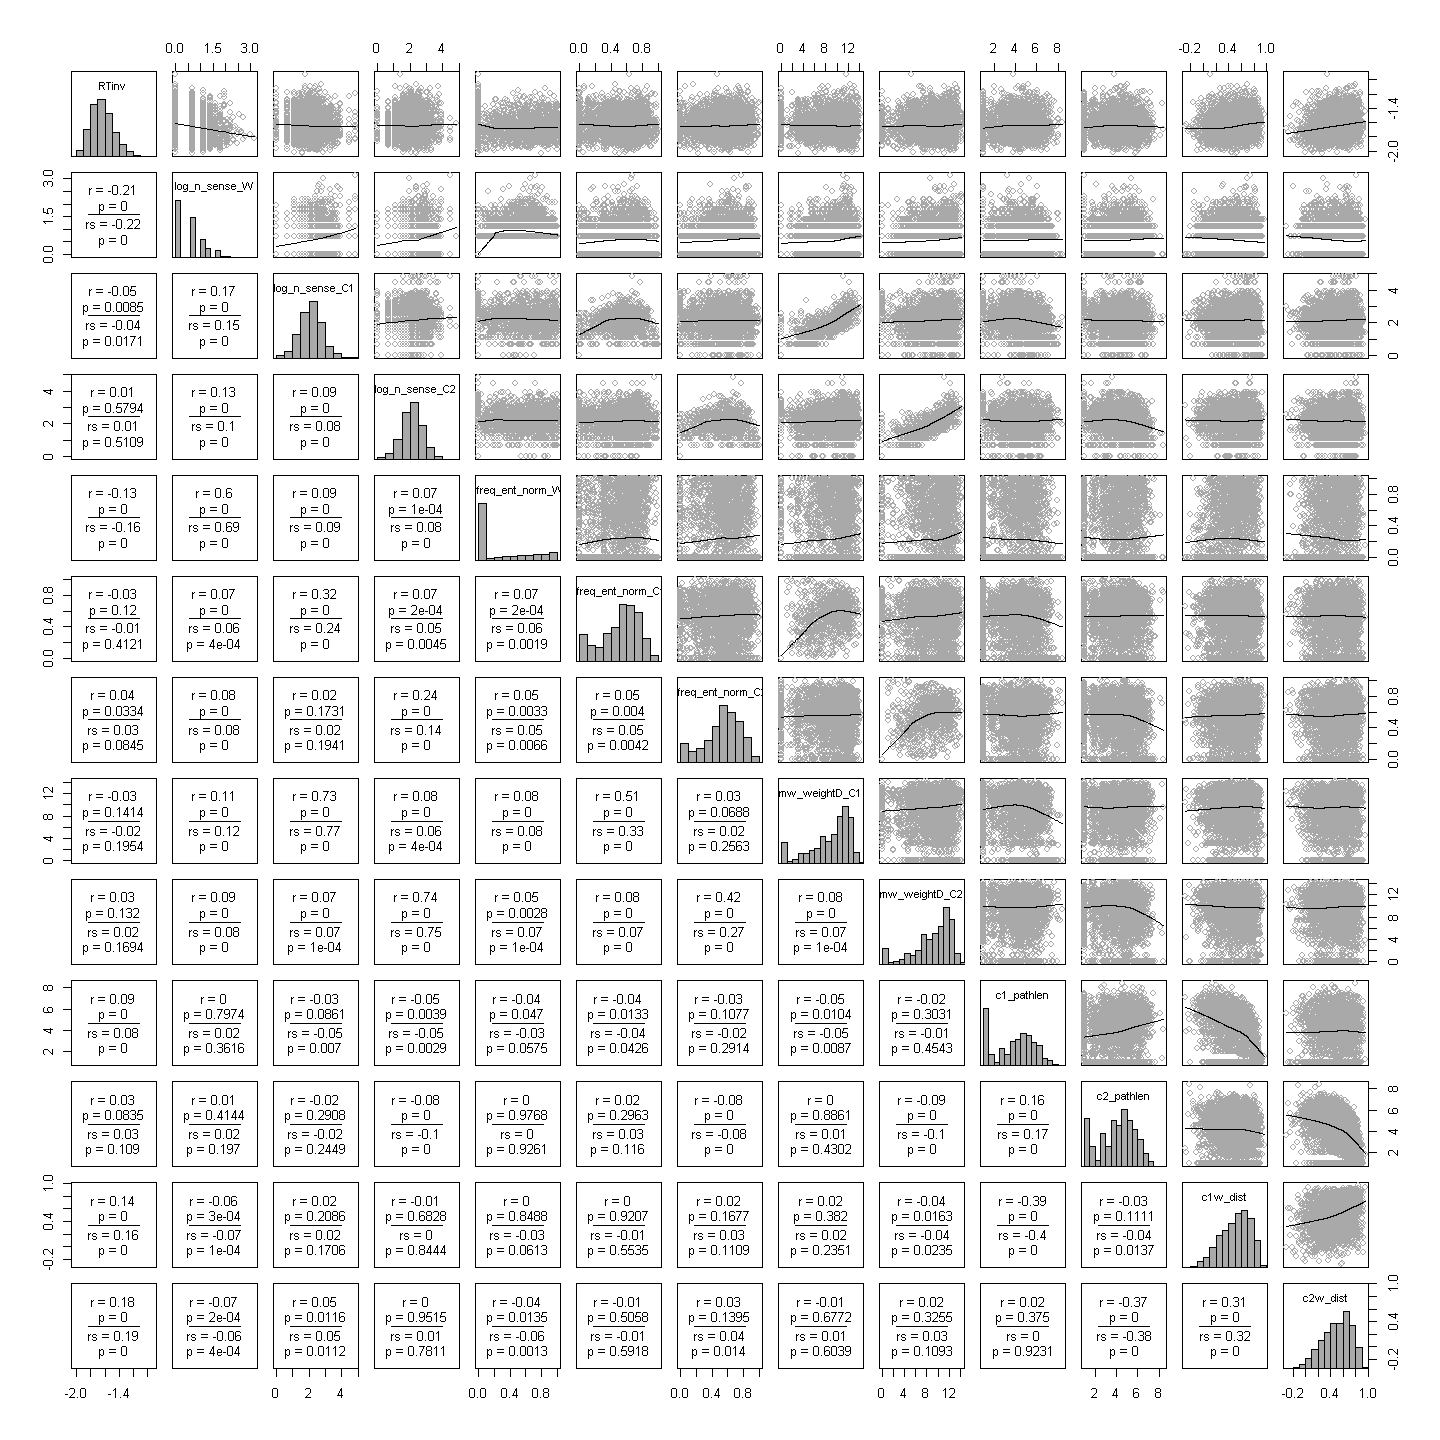

In [7]:
clp_variables = c("RTinv", 
                  "log_n_sense_W", "log_n_sense_C1", "log_n_sense_C2",
                  "sfreq_ent_norm_W", "sfreq_ent_norm_C1", "sfreq_ent_norm_C2",
                  "mw_weightD_C1", "mw_weightD_C2", "c1_pathlen", "c2_pathlen",
                  "c1w_dist", "c2w_dist")
options(repr.plot.width=12, repr.plot.height=12)

pairscor.fnc(clp[,c(clp_variables)])

## Variable importance

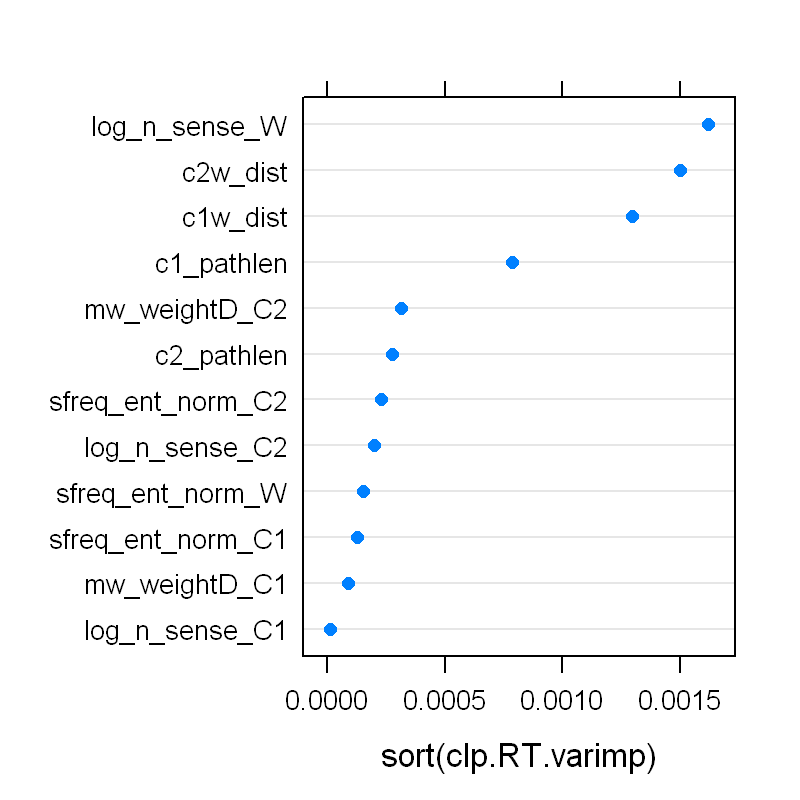

In [8]:
popt(4,4,200)
clp_variables = c("RTinv", 
                  "log_n_sense_W", "log_n_sense_C1", "log_n_sense_C2",
                  "sfreq_ent_norm_W", "sfreq_ent_norm_C1", "sfreq_ent_norm_C2",
                  "mw_weightD_C1", "mw_weightD_C2",
                  "c1_pathlen", "c2_pathlen",
                  "c1w_dist", "c2w_dist")
clp.RT.cf <- cforest(RTinv ~ ., data=clp[,clp_variables])
clp.RT.varimp = varimp(clp.RT.cf)
options(repr.plot.width=4, repr.plot.height=4)
dotplot(sort(clp.RT.varimp), main=list(cex=2))

In [9]:
m.0 = bam(RTinv~s(log_freq_W)+s(log_freq_C1)+s(log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)
          +s(sfreq_ent_norm_C1)+s(sfreq_ent_norm_C2)
          +s(mw_weightD_C1)+s(mw_weightD_C2)
          +s(c1w_dist)+s(c2w_dist), data=clp)

In [11]:
summary(m.0)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + s(mw_weightD_C1) + s(mw_weightD_C2) + 
    s(c1w_dist) + s(c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002345  -698.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                       edf Ref.df       F  p-value    
s(log_freq_W)        3.469  4.416 245.583  < 2e-16 ***
s(log_freq_C1)       2.521  3.226  17.965  < 2e-16 ***
s(log_freq_C2)       4.266  5.345  16.072  < 2e-16 ***
s(log_n_sense_W)     1.632  2.014   6.294 0.001881 ** 
s(log_n_sense_C1)    1.000  1.000   7.438 0.006425 ** 
s(log_n_sense_C2)    2.323  2.996   1.183 0.315137    
s(sfreq_ent_norm_C1) 5.401  6.542   3.979 0.000313 ***
s(sfreq_ent_norm_C2)

In [12]:
m.10 = bam(RTinv~s(log_freq_W)+s(log_freq_C1)+s(log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)          
          +s(sfreq_ent_norm_C1)+s(sfreq_ent_norm_C2)
          +s(c1w_dist)+s(c2w_dist), data=clp)

In [13]:
compareML(m.0, m.10)

m.0: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + s(mw_weightD_C1) + s(mw_weightD_C2) + 
    s(c1w_dist) + s(c2w_dist)

m.10: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + s(c1w_dist) + s(c2w_dist)

Model m.10 preferred: lower fREML score (7.226), and lower df (4.000).
-----
  Model     Score Edf Difference    Df
1   m.0 -1822.292  25                 
2  m.10 -1829.517  21     -7.226 4.000

AIC difference: 0.81, model m.10 has lower AIC.



In [14]:
m.11 = bam(RTinv~s(log_freq_W)+s(log_freq_C1)+s(log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)          
          +s(sfreq_ent_norm_C1)+s(sfreq_ent_norm_C2)     
          +te(c1w_dist, c2w_dist), data=clp)

In [15]:
summary(m.11)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002342  -699.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                        edf Ref.df       F  p-value    
s(log_freq_W)         3.436  4.376 246.147  < 2e-16 ***
s(log_freq_C1)        2.211  2.830  20.364  < 2e-16 ***
s(log_freq_C2)        4.397  5.490  15.788  < 2e-16 ***
s(log_n_sense_W)      1.542  1.893   7.009 0.003325 ** 
s(log_n_sense_C1)     1.000  1.000   3.884 0.048845 *  
s(log_n_sense_C2)     2.949  3.756   1.501 0.198388    
s(sfreq_ent_norm_C1)  5.401  6.536   3.603 0.000838 ***
s(sfreq_ent_norm_C2)  1.000  1.000  23.429 1.84e-06 ***
te

In [16]:
compareML(m.10, m.11)

m.10: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + s(c1w_dist) + s(c2w_dist)

m.11: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df   p.value Sig.
1  m.10 -1829.517  21                                
2  m.11 -1838.112  22      8.594 1.000 3.384e-05  ***

AIC difference: 9.15, model m.11 has lower AIC.



In [17]:
m.2 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)          
          +s(sfreq_ent_norm_C1)+s(sfreq_ent_norm_C2)     
          +te(c1w_dist, c2w_dist), data=clp)

In [18]:
summary(m.2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002337  -700.5   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                              edf Ref.df       F  p-value    
s(log_freq_W)               3.452  4.396 248.477  < 2e-16 ***
te(log_freq_C1,log_freq_C2) 9.594 12.021  14.827  < 2e-16 ***
s(log_n_sense_W)            1.474  1.798   7.555 0.003351 ** 
s(log_n_sense_C1)           1.000  1.000   4.417 0.035662 *  
s(log_n_sense_C2)           2.774  3.545   1.379 0.233679    
s(sfreq_ent_norm_C1)        5.489  6.630   3.611 0.000749 ***
s(sfreq_ent_norm_C2)        1.000  1.000  23.057 2.28e-06 ***
te(c1w_dist,c

In [19]:
compareML(m.11, m.2)

m.11: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df   p.value Sig.
1  m.11 -1838.112  22                                
2   m.2 -1846.265  23      8.153 1.000 5.387e-05  ***

AIC difference: 6.08, model m.2 has lower AIC.



In [41]:
m.3 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)
          +te(log_n_sense_C1, log_n_sense_C2)          
          +s(sfreq_ent_norm_C1)+s(sfreq_ent_norm_C2)     
          +te(c1w_dist, c2w_dist), data=clp)

In [42]:
summary(m.3)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    te(log_n_sense_C1, log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002338  -700.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                                    edf Ref.df       F  p-value    
s(log_freq_W)                     3.521  4.479 244.432  < 2e-16 ***
te(log_freq_C1,log_freq_C2)       9.490 11.882  14.815  < 2e-16 ***
s(log_n_sense_W)                  1.330  1.583   8.679 0.002542 ** 
te(log_n_sense_C1,log_n_sense_C2) 4.214  4.845   2.279 0.043808 *  
s(sfreq_ent_norm_C1)              5.533  6.677   3.552 0.000845 ***
s(sfreq_ent_norm_C2)              1.000  1.000  22.800 2.04e-06 ***
te(c1w_dist,c2w_dist)             5.

In [43]:
compareML(m.2, m.3)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

m.3: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    te(log_n_sense_C1, log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1   m.2 -1846.265  23                              
2   m.3 -1851.172  24      4.907 1.000   0.002  ** 

AIC difference: -0.32, model m.2 has lower AIC.



Warning message in compareML(m.2, m.3):
"Only small difference in fREML...
"


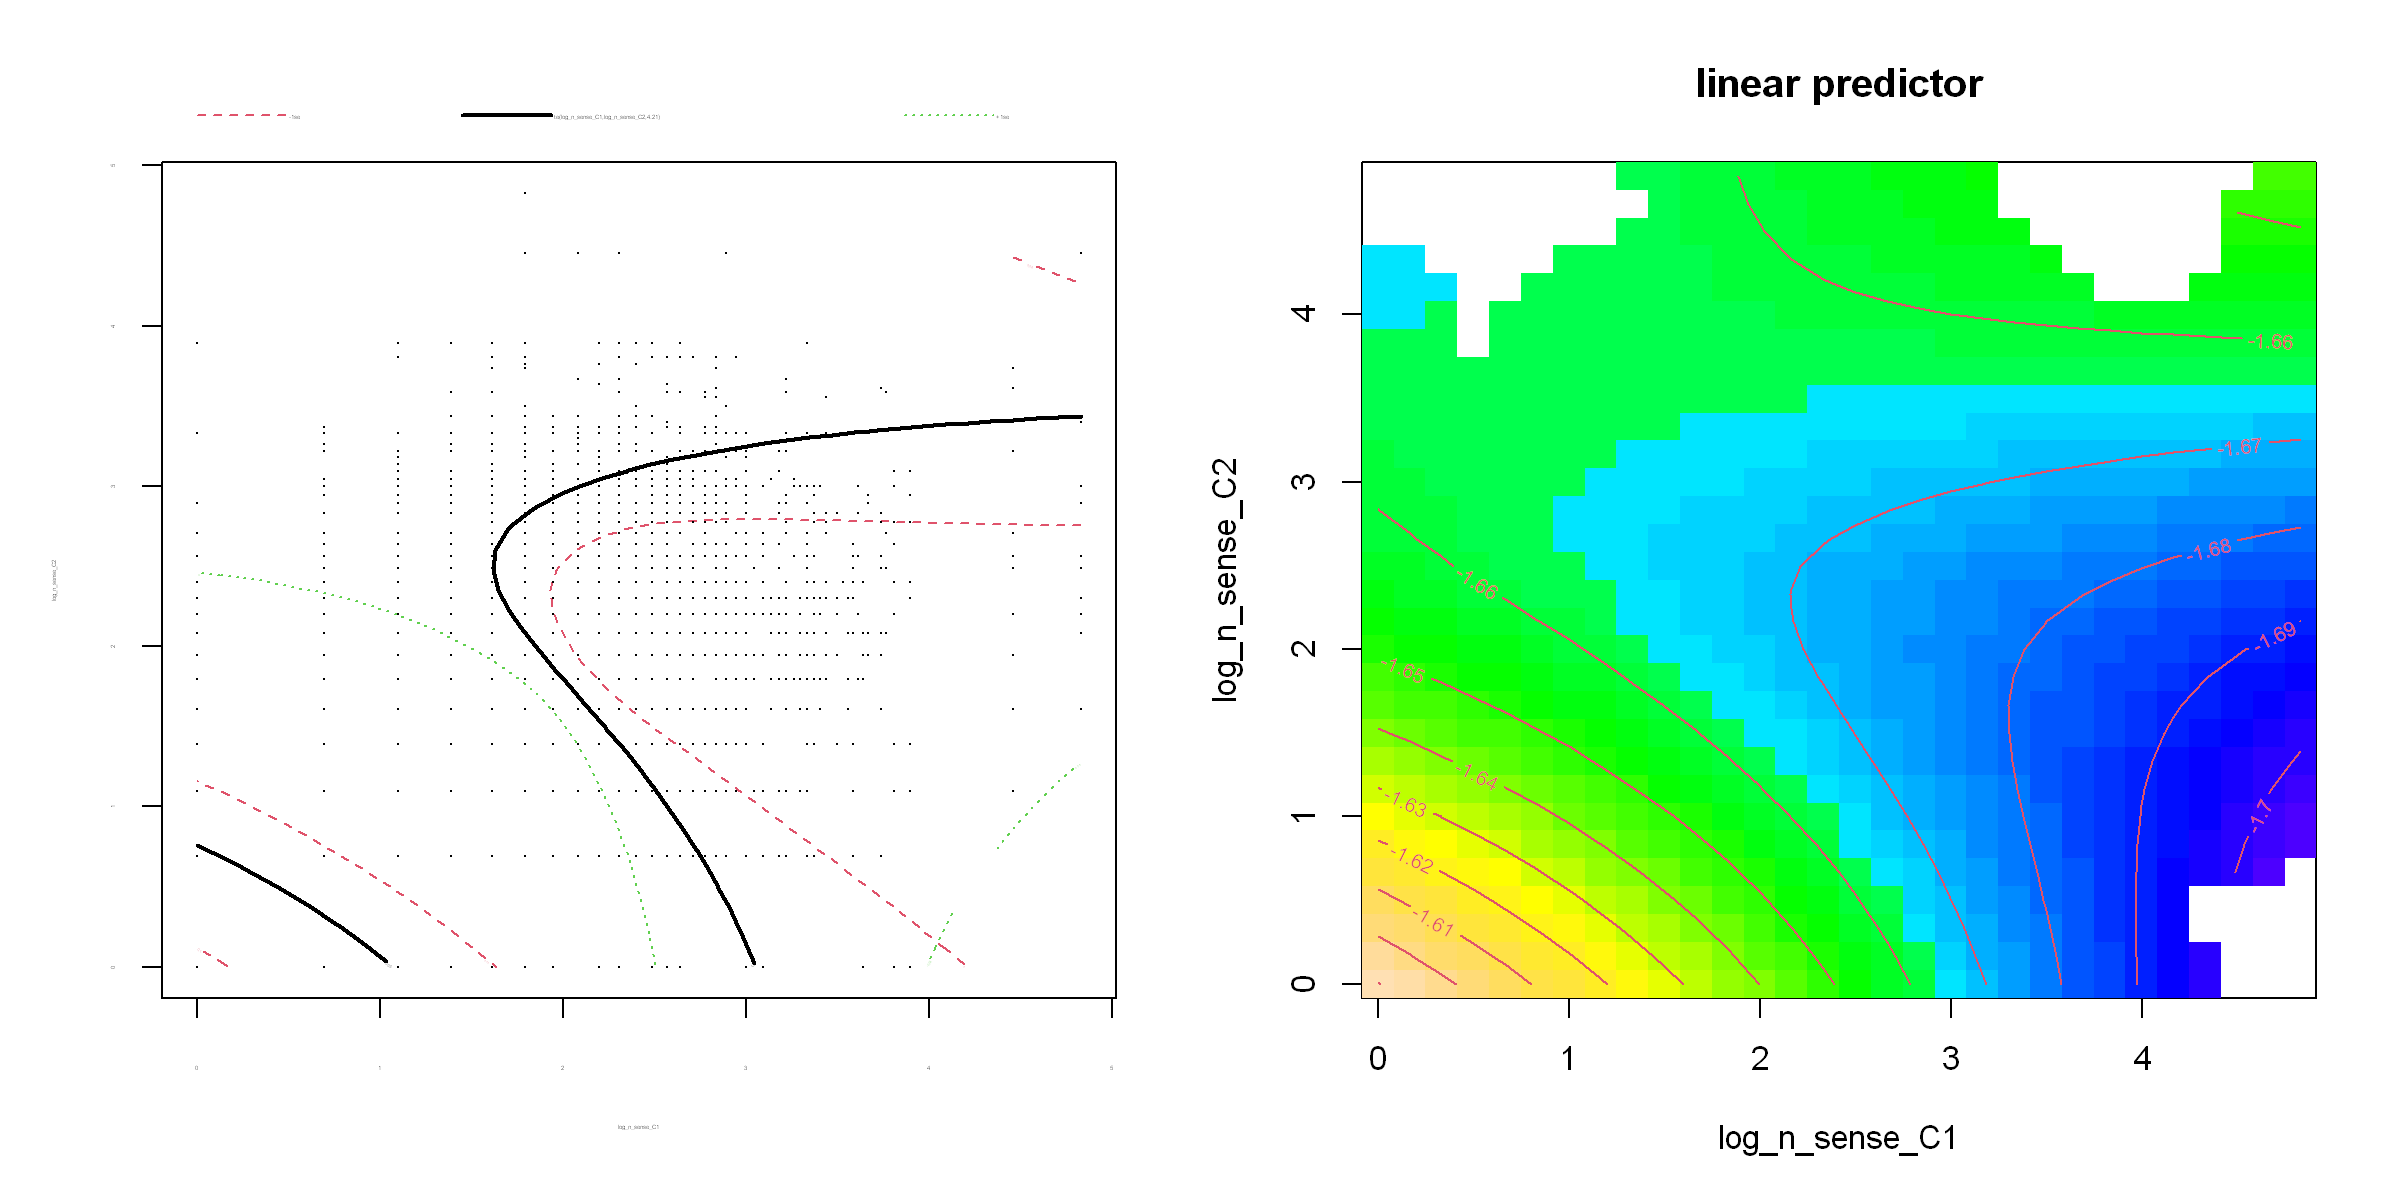

In [53]:
plot_int(m.3, 4, "log_n_sense_C1", "log_n_sense_C2")

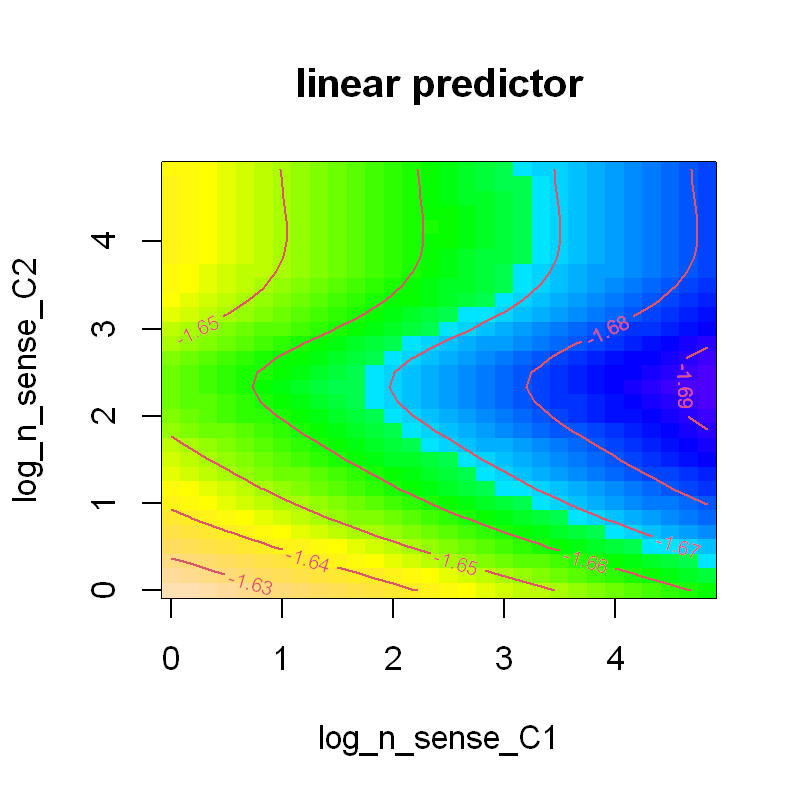

In [26]:
## log_n_sense_C1 / log_n_sense_C2 without using tensor-product bases
popt(4, 4)
vis.gam(m.2, view=c("log_n_sense_C1", "log_n_sense_C2"), plot.type="contour", color="topo")

In [67]:
m.31 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)
          +s(log_n_sense_C1)+s(log_n_sense_C2)          
          +te(sfreq_ent_norm_C1, sfreq_ent_norm_C2) 
          +te(c1w_dist, c2w_dist), data=clp)

In [68]:
summary(m.31)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + te(sfreq_ent_norm_C1, 
    sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002337  -700.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                                          edf Ref.df       F  p-value    
s(log_freq_W)                           3.508  4.462 245.225  < 2e-16 ***
te(log_freq_C1,log_freq_C2)             9.574 11.945  15.061  < 2e-16 ***
s(log_n_sense_W)                        1.506  1.844   7.243  0.00355 ** 
s(log_n_sense_C1)                       1.000  1.000   3.775  0.05211 .  
s(log_n_sense_C2)                       2.754  3.518   1.378  0.23307    
te(sfreq_ent_norm_C1,sfreq_ent_norm_C2) 8.245 10.411   4.550 1.42e-0

In [69]:
compareML(m.2, m.31)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sfreq_ent_norm_C1) + 
    s(sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

m.31: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + te(sfreq_ent_norm_C1, 
    sfreq_ent_norm_C2) + te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1   m.2 -1846.265  23                              
2  m.31 -1850.767  24      4.502 1.000   0.003  ** 

AIC difference: -1.79, model m.2 has lower AIC.



Warning message in compareML(m.2, m.31):
"Only small difference in fREML...
"


## Visualization

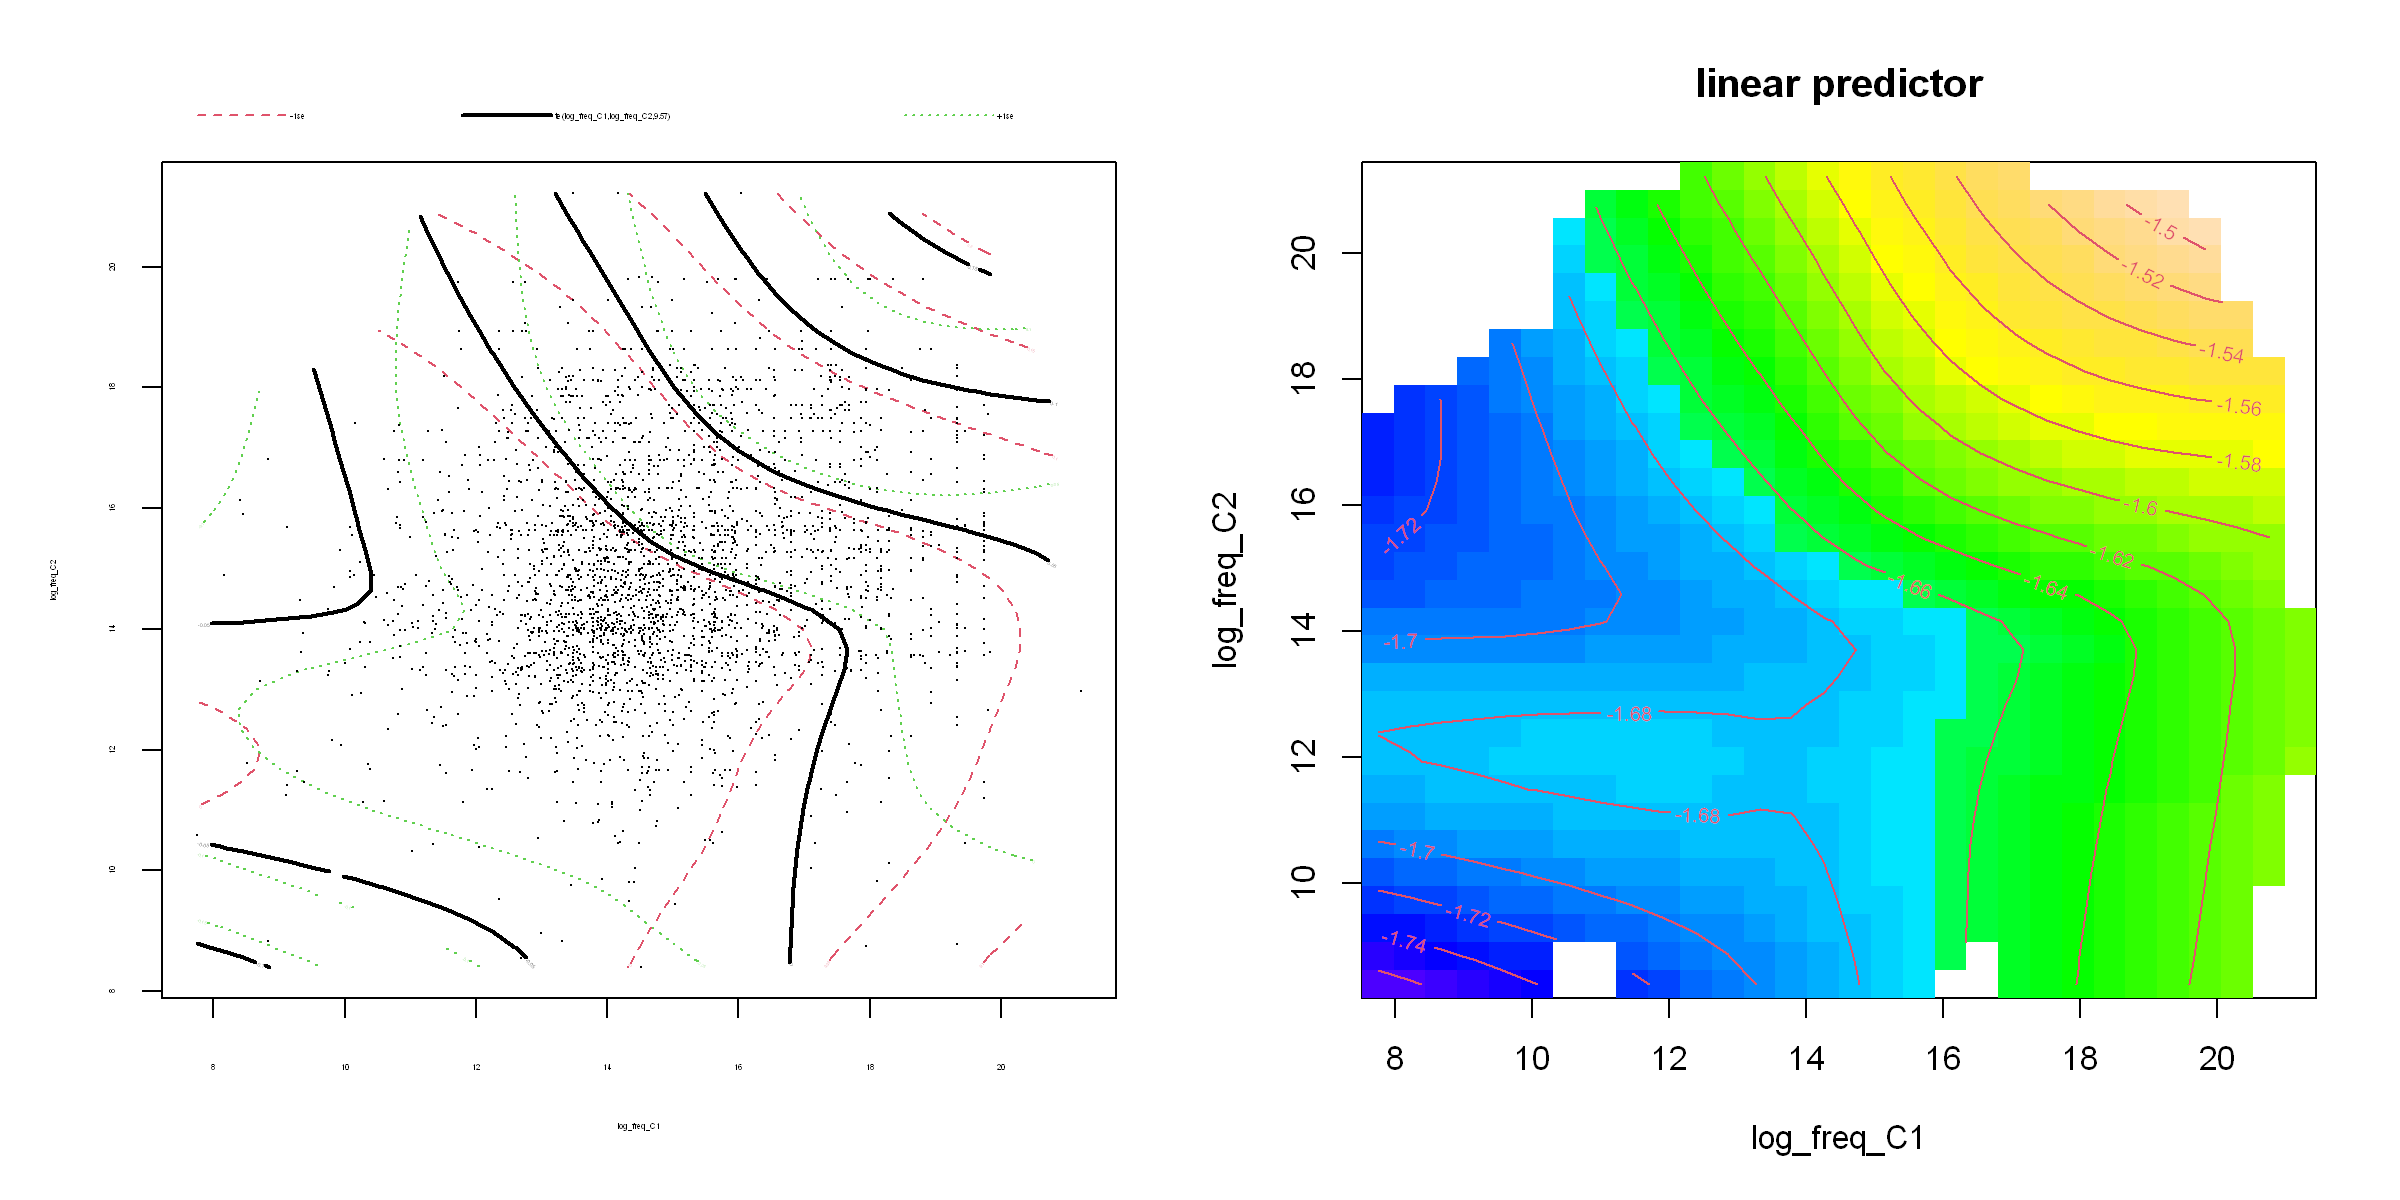

In [48]:
popt(8, 4, 200)
plot_int(m.31, 2, "log_freq_C1", "log_freq_C2")

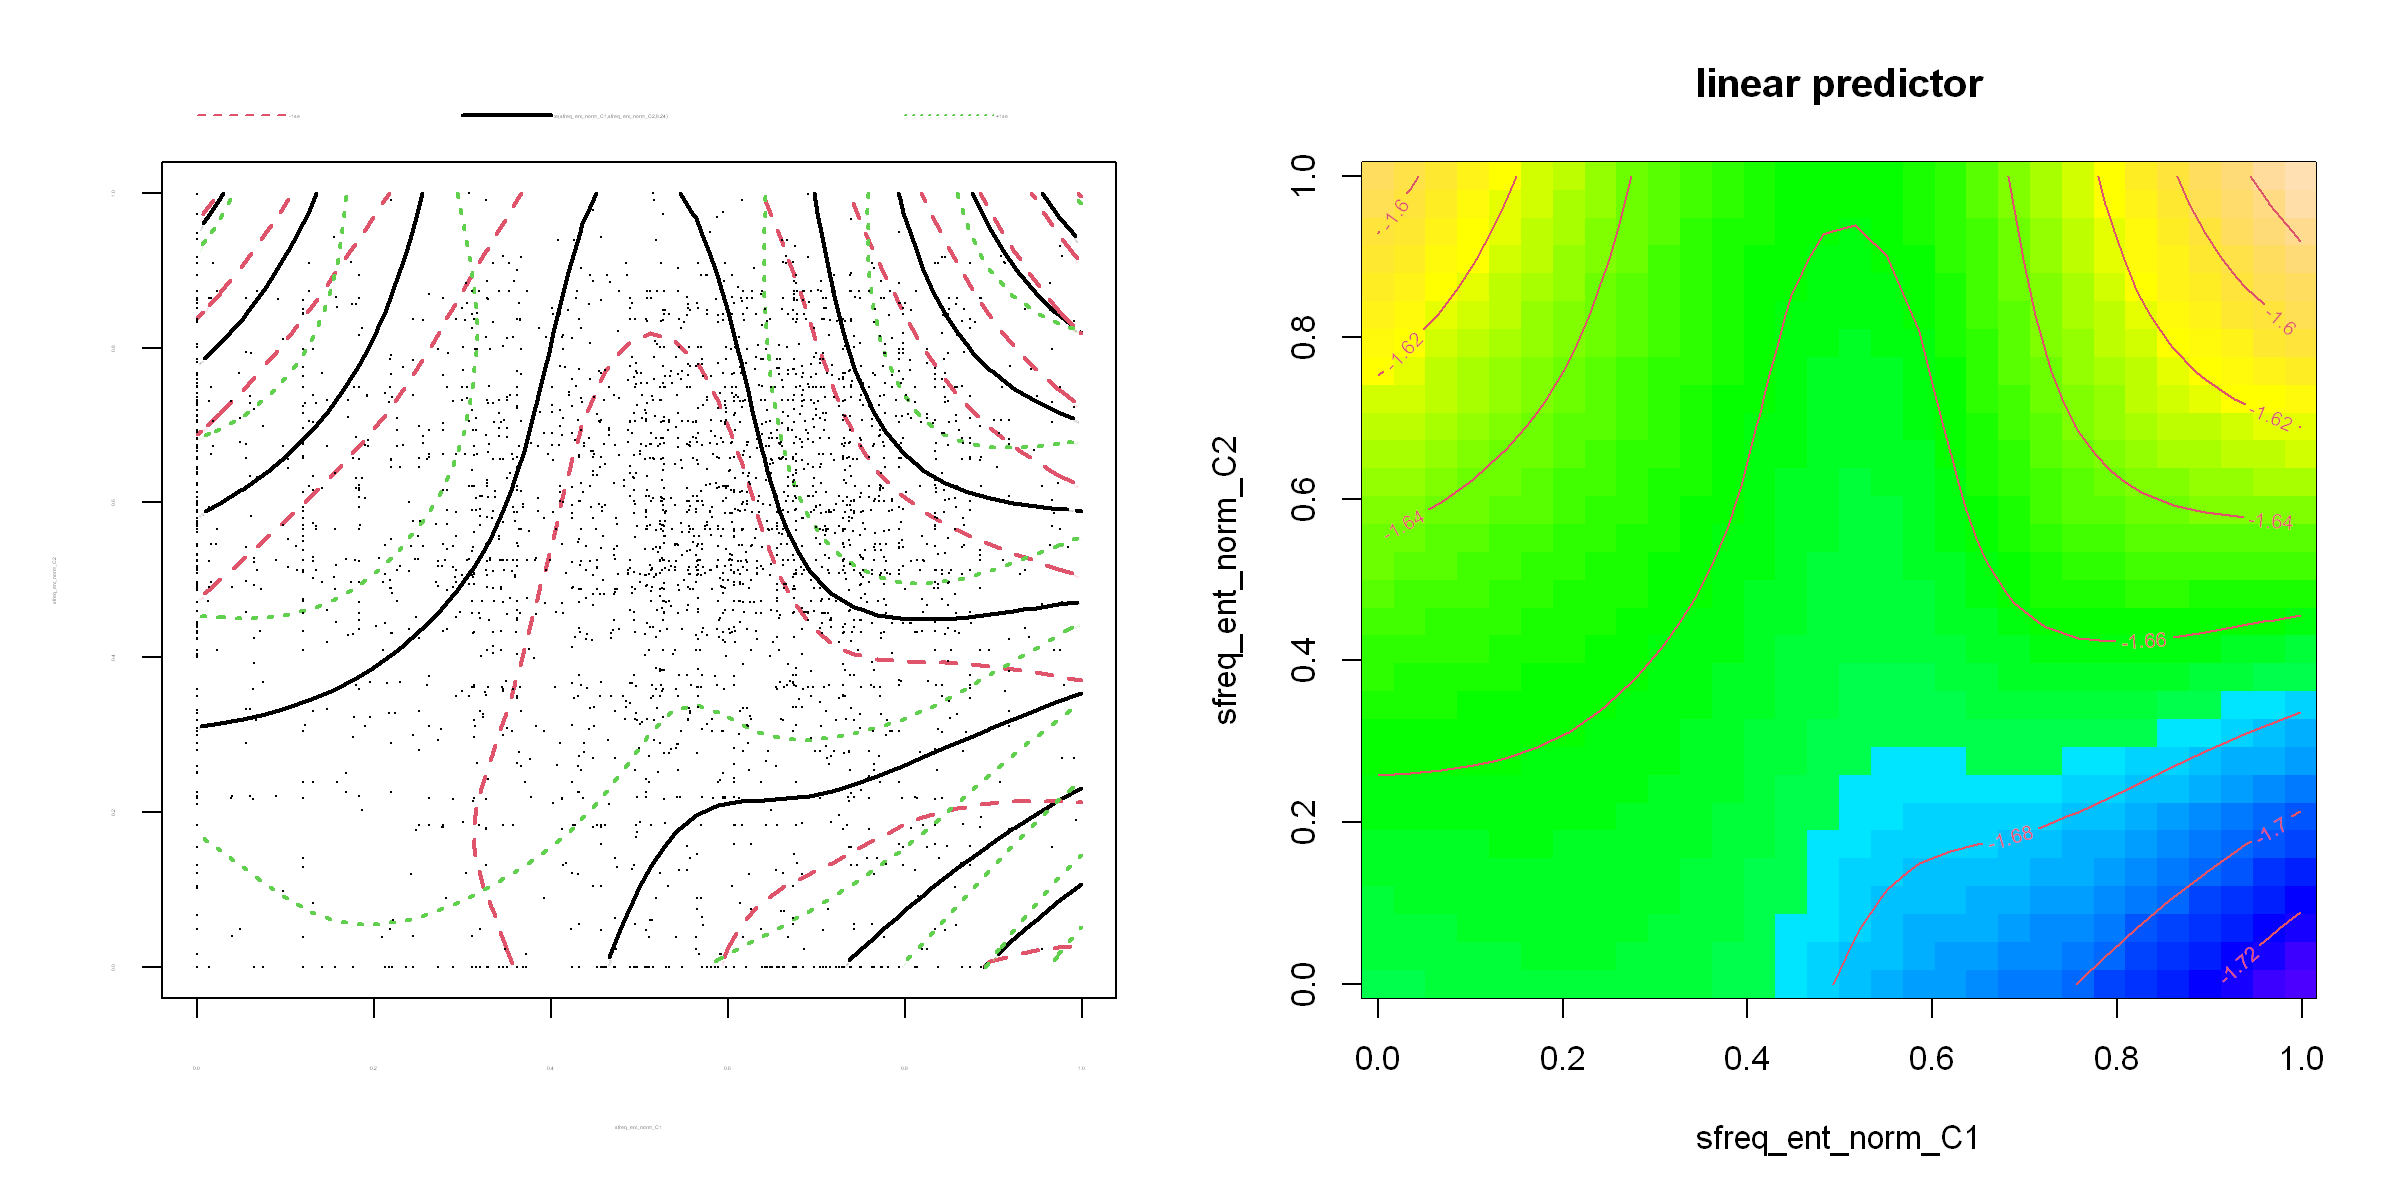

In [70]:
popt(8, 4, 200)
plot_int(m.31, 6, "sfreq_ent_norm_C1", "sfreq_ent_norm_C2")

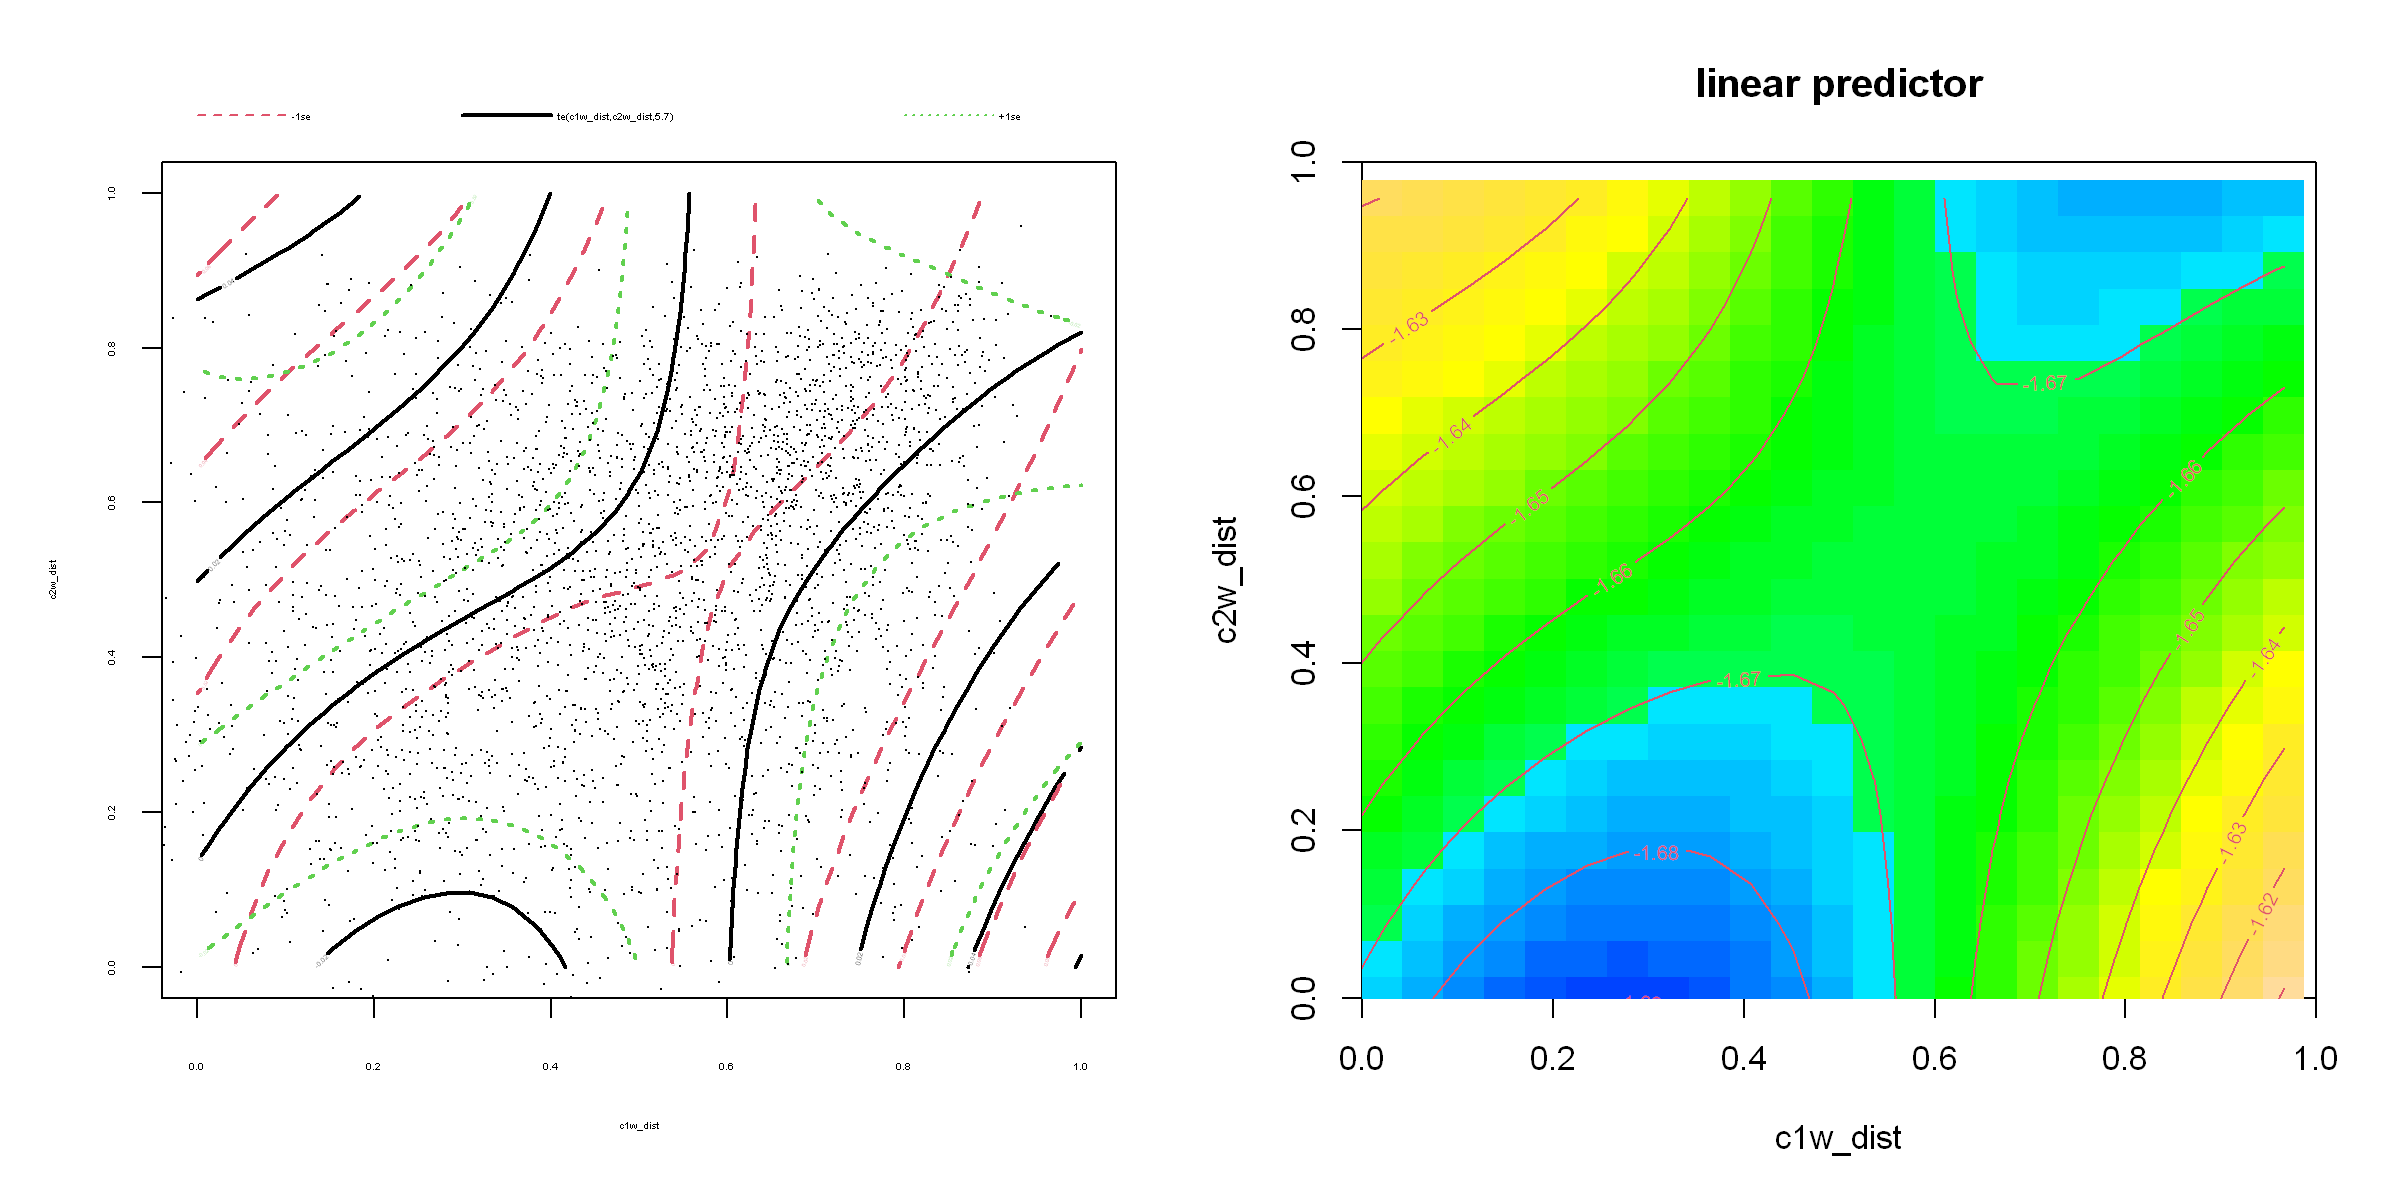

In [59]:
popt(8, 4, 200)
plot_int(m.31, 7, "c1w_dist", "c2w_dist", xlim=c(0,1), ylim=c(0,1))